# PlantCV Setaria Panicle Analysis Tutorial

About this notebook:

Written by Haley Schuhl for Eveland Lab for getting phenotypes (bristle count, panicle color and size characteristics) from dissected setaria panicles. 

Updated: July, 2025

In [ ]:
# Install PlantCV and required dependencies
%pip install "altair>=5" plantcv

# Give access and mount your Google Drive (need a Google Account)
# Change path to directory you wish output files to be saved to.
from google.colab import drive
drive.mount('/content/gdrive')

# Enable widget feature with matplotlib
from google.colab import output
output.enable_custom_widget_manager()

#View working directory, may need to change path
%pwd

In [1]:
# Set plotting backend
%matplotlib widget
# Import software packages to be used
from plantcv import plantcv as pcv

# Set parameters PlantCV is using to create debug figures and warning statements 
pcv.params.debug = "plot" 
pcv.params.verbose = False # quiet warnings 

# Read image data into workflow 

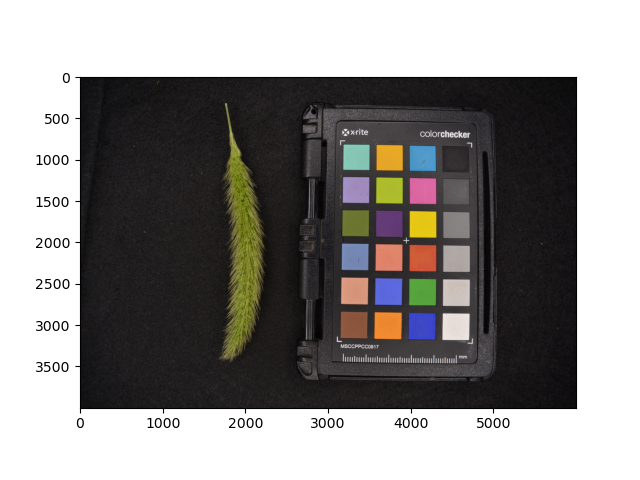

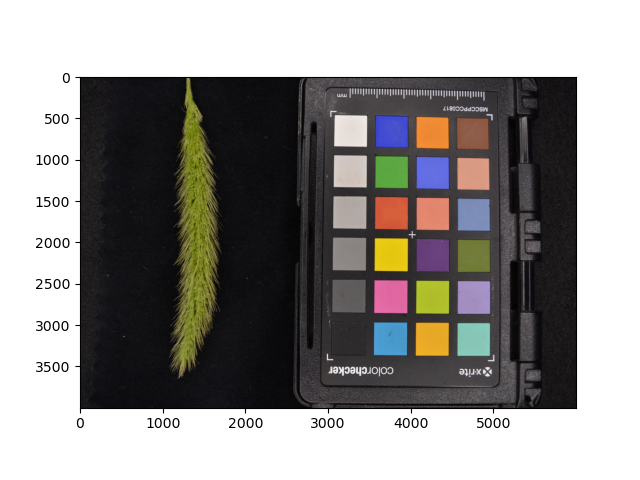

In [ ]:
## Read Image data 
img = pcv.io.open_url(url="https://raw.githubusercontent.com/danforthcenter/plantcv-tutorial-setaria-panicle/main/img/panicle-img.JPG")

# Apply color standardization
The function [pcv.threshold.auto_correct_color](https://plantcv.readthedocs.io/en/latest/transform_auto_correct_color/) first runs the detection function (pcv.transform.detect_color_card) and then uses the manufacturer's color values to standardize colorspace in image data.

The color card chips sizes are also recorded to Outputs and therefore can be used to standardize size (convert pixels to mm and mm<sup>2</sup>)

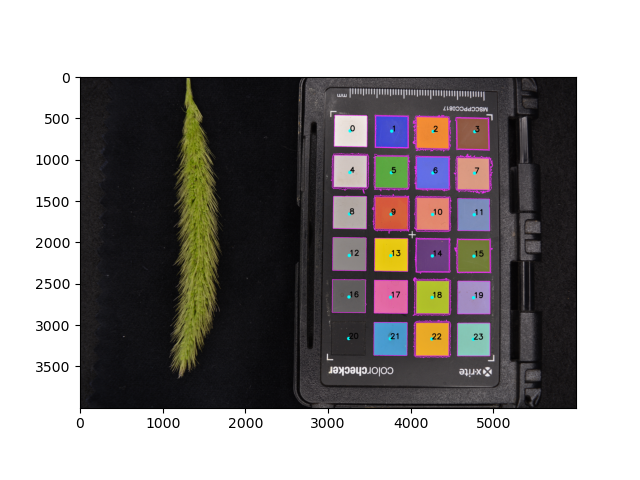

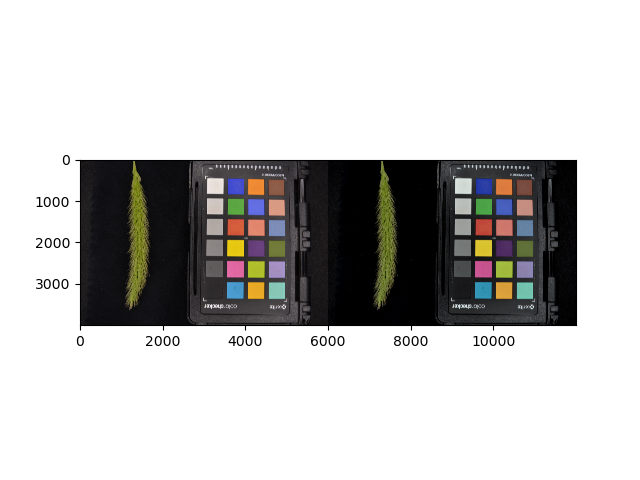

In [ ]:
# Size debugging parameters for better readability of labels 
pcv.params.text_size = 3
pcv.params.text_thickness = 10

# Standarize color with color card
img = pcv.transform.auto_correct_color(rgb_img=img)

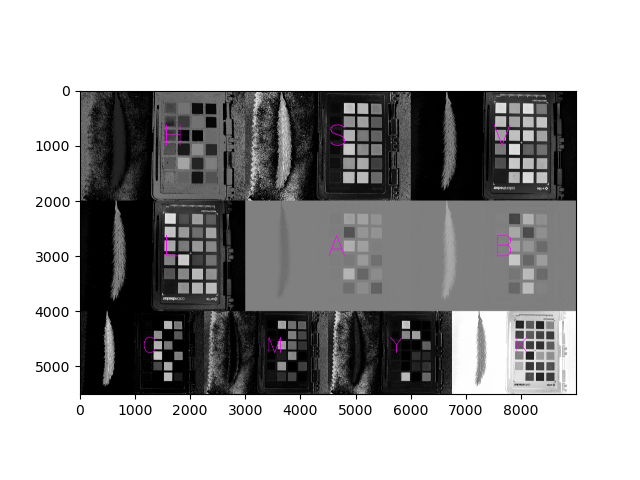

In [ ]:
# Look at all colorspaces to pick one for segmentation 
pcv.params.text_size = 35
pcv.params.text_thickness = 25
_ = pcv.visualize.colorspaces(img, False)

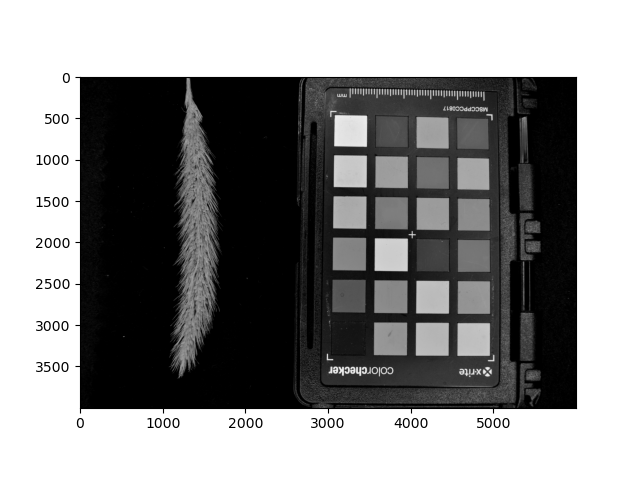

In [6]:
# Use the "lightness" channel from LAB colorspace
l = pcv.rgb2gray_lab(rgb_img=img, channel="l")

## Use Adaptive Threshold to segment fine bristle tips 

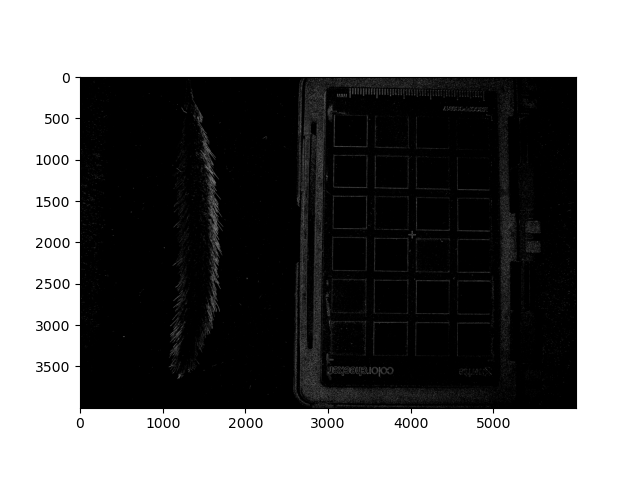

In [7]:
bin_gauss1 = pcv.threshold.gaussian(gray_img=l, ksize=3, offset=-4,
                                    object_type='light')



## Use binary segmentation to capture the rest of the panicle

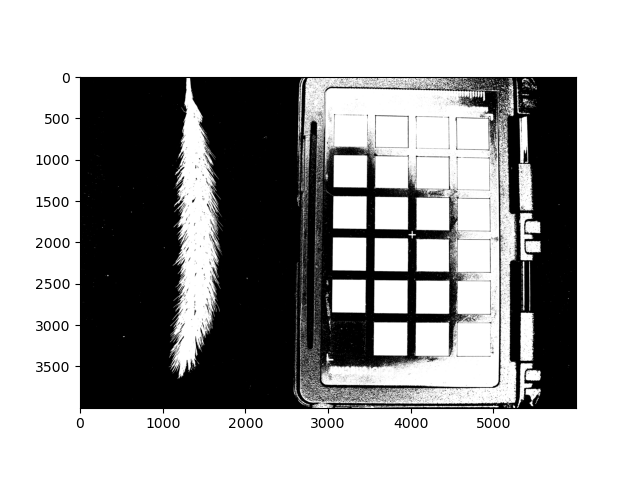

In [8]:
mask = pcv.threshold.binary(gray_img=l, threshold=40)

## Combine masks

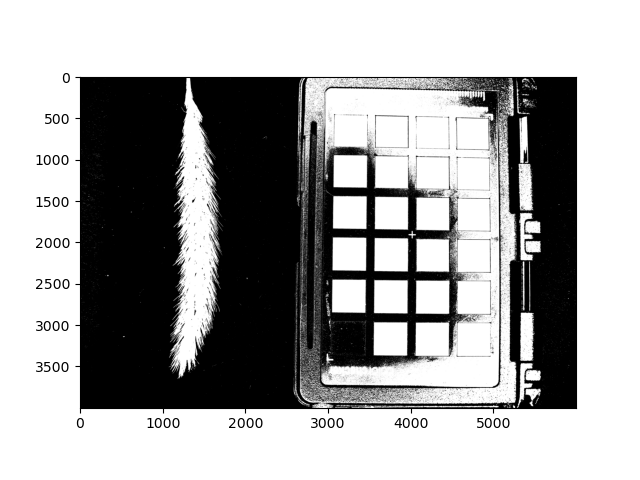

In [9]:
mask = pcv.logical_or(bin_img1=mask, bin_img2=bin_gauss1)

## Mask Cleaning 

Use a size filter to clean small "salt" noise, then a regional filter to clean the mask for thresholding setaria panicle from background (including the colorcard). 

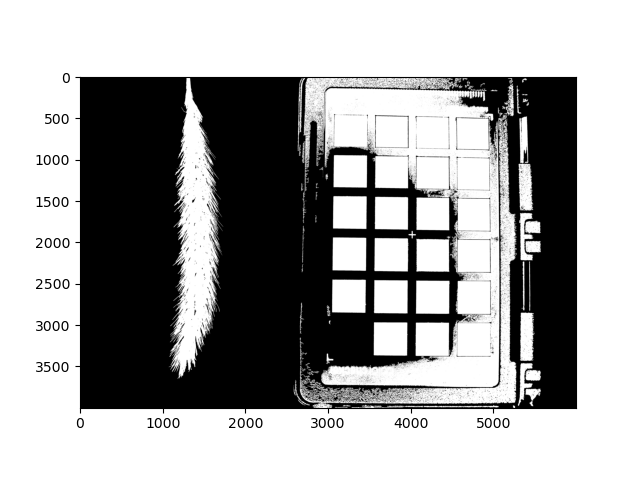

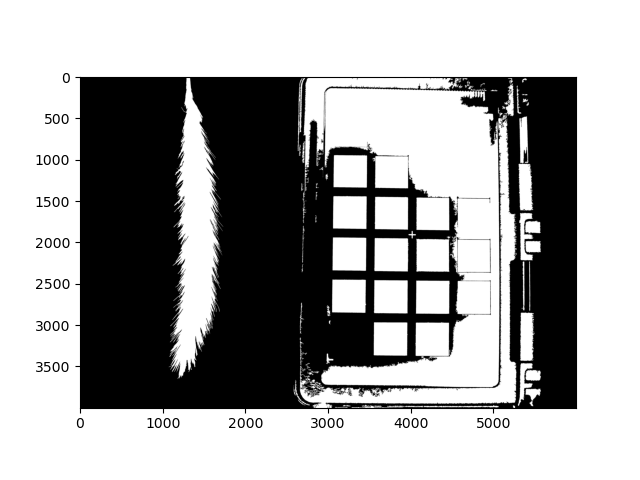

In [10]:
# Fill in "salt" noise in the background 
clean_mask = pcv.fill(mask, size=500)

# Fill holes inside the panicle 
clean_mask = pcv.fill_holes(clean_mask)

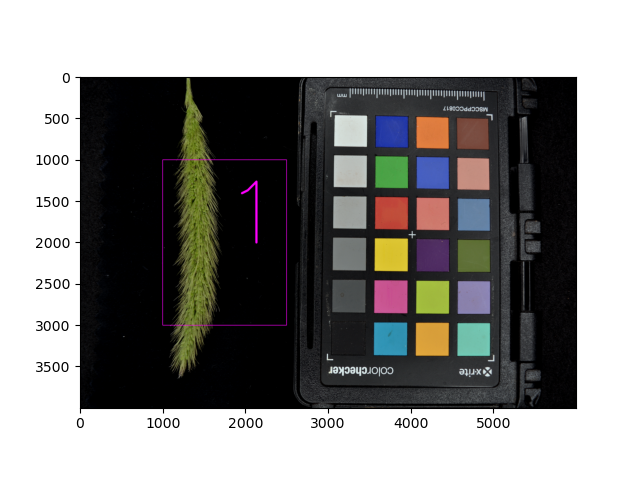

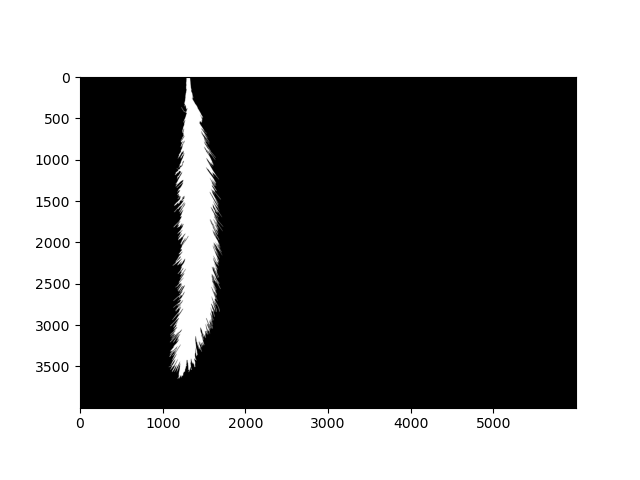

In [11]:
# Define a region of interest to remove the color card from the panicle mask 
roi = pcv.roi.rectangle(img=img, x=1000, y=1000, h=2000, w=1500)
clean_mask = pcv.roi.filter(roi=roi, mask=clean_mask)


# Skeletonization

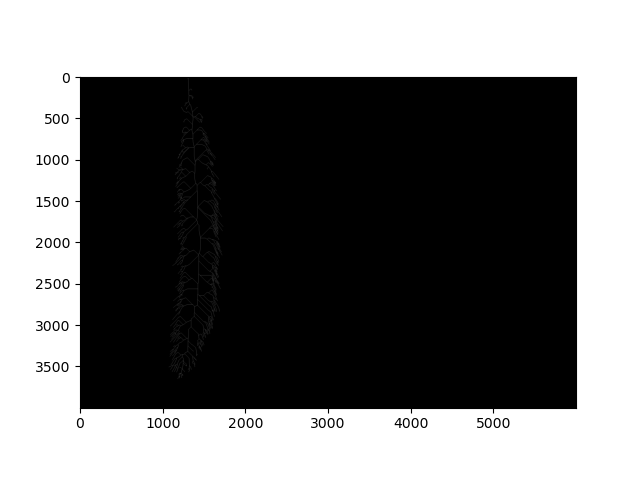

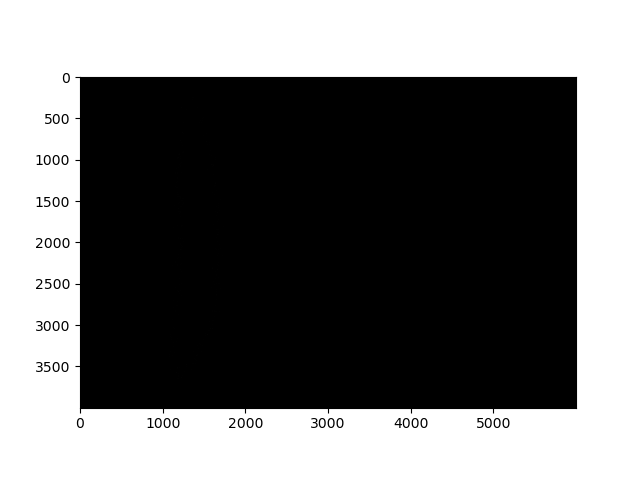

In [12]:
# Try skeletonization to ID bristle tips 
skeleton = pcv.morphology.skeletonize(mask=clean_mask)
tips_img = pcv.morphology.find_tips(skel_img=skeleton, mask=clean_mask)


## Can the y-coordinates of branch points be used to estimate the panicle length? 

Maybe, but if it's possible to trim the panicle to only the part that is of interest for measurement, then this will probably be more accurate than trying to use an algorithm to find where bristling starts. 

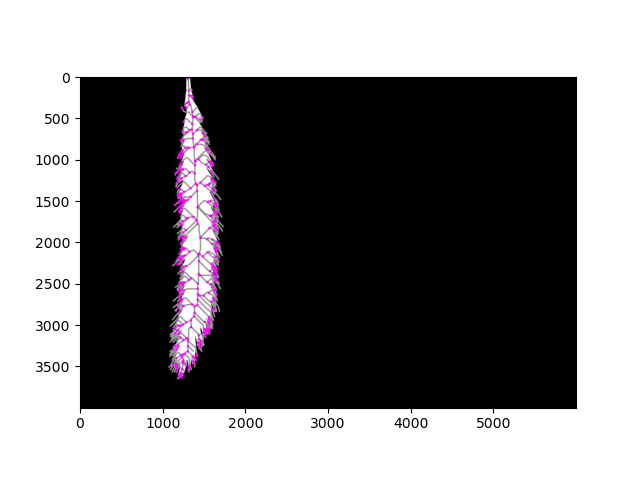

In [13]:
pcv.params.line_thickness = 15
branch_pts = pcv.morphology.find_branch_pts(skel_img=skeleton, mask=clean_mask)


# Find bristle estimated count with pcv.homology.acute

/Users/hschuhl/miniforge3/envs/plantcv_test/lib/python3.13/site-packages/plantcv/plantcv/homology/acute.py:152: RuntimeWarning: overflow encountered in scalar add
  ptvals.append(sum(vals)/len(vals))


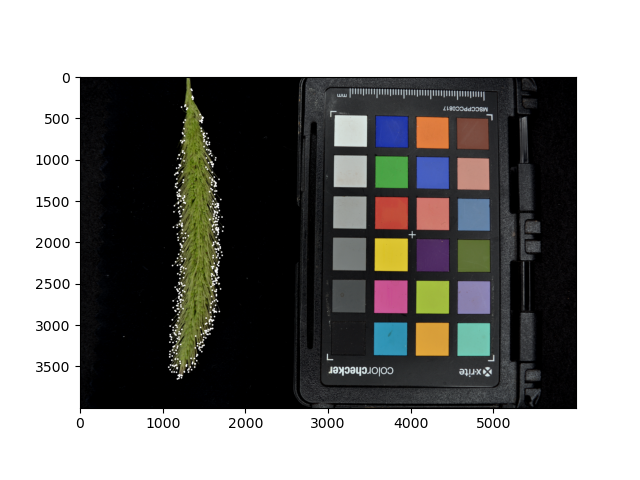

514


In [14]:
pcv.params.line_thickness = 20
pcv.params.verbose = False

homolog_pts, start_pts, stop_pts, ptvals, chain, max_dist = pcv.homology.acute(img=img, mask=clean_mask, win=5, threshold=90)
print(len(homolog_pts)) # Print the number of points detected 

# Create a new measurement, save estimated count to Outputs class 
pcv.outputs.add_observation(sample='default', variable='bristle_count_win5', 
                            trait='estimated number of bristles',
                            method='pcv.homology.acute(win=5, threshold=90)', scale='none', datatype=int,
                            value=len(homolog_pts), label='none')

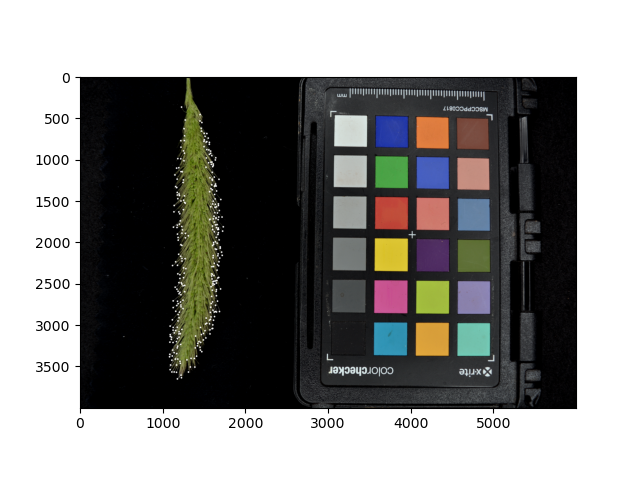

318


In [15]:
# Larger window (number of maximum pixels in angle score calculation) 
homolog_pts, start_pts, stop_pts, ptvals, chain, max_dist = pcv.homology.acute(img=img, mask=clean_mask, win=25, threshold=90)
print(len(homolog_pts)) # there are fewer bristles detected, so maybe "win" size also describes minimum distance between tips detectable 
pcv.outputs.add_observation(sample='default', variable='bristle_count_win25', 
                            trait='estimated number of bristles',
                            method='pcv.homology.acute(win=25, threshold=90)', scale='none', datatype=int,
                            value=len(homolog_pts), label='none')

# Measure panicle size and color 

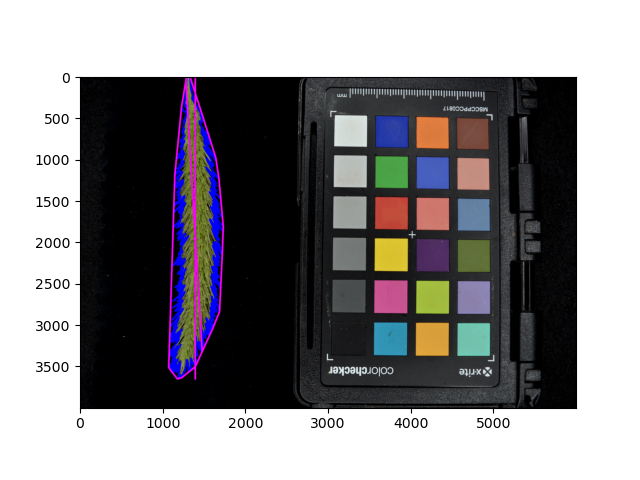

alt.FacetChart(...)

In [16]:
_ = pcv.analyze.size(img=img, labeled_mask=clean_mask, n_labels=1) ## This includes ~14 phenotypes and includes height & longest_path which both might correlate well to panicle length 
_ = pcv.analyze.color(rgb_img=img, labeled_mask=clean_mask, n_labels=1)

# Save results to file

In [ ]:
pcv.outputs.save_results(filename="test_results.json")